In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import talib as ta

In [12]:
years=int(input('Anios de historico que quieres recuperar:'))
ticker_symbol=input('ticker:')
end_date= dt.datetime.now() 
start_date = end_date- dt.timedelta(365*years) 

ticker = yf.Ticker(ticker_symbol)

# Obtener el historial de precios
# period='5d' # 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
interval='1d' # 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

# bajamos los datos
ticker_data = ticker.history(start=start_date, end=end_date, interval=interval)
# ticker_data = ticker.history(period=period, interval=interval)
# print(ticker_data)

In [13]:
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

In [14]:
data = ticker_data.copy()
data['Close']
data['macd'], data['macdSignal'], data['macdHist'] = ta.MACD(data['Close'],fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
data['macd_test'] = np.where((data.macd > data.macdSignal), 1, 0)


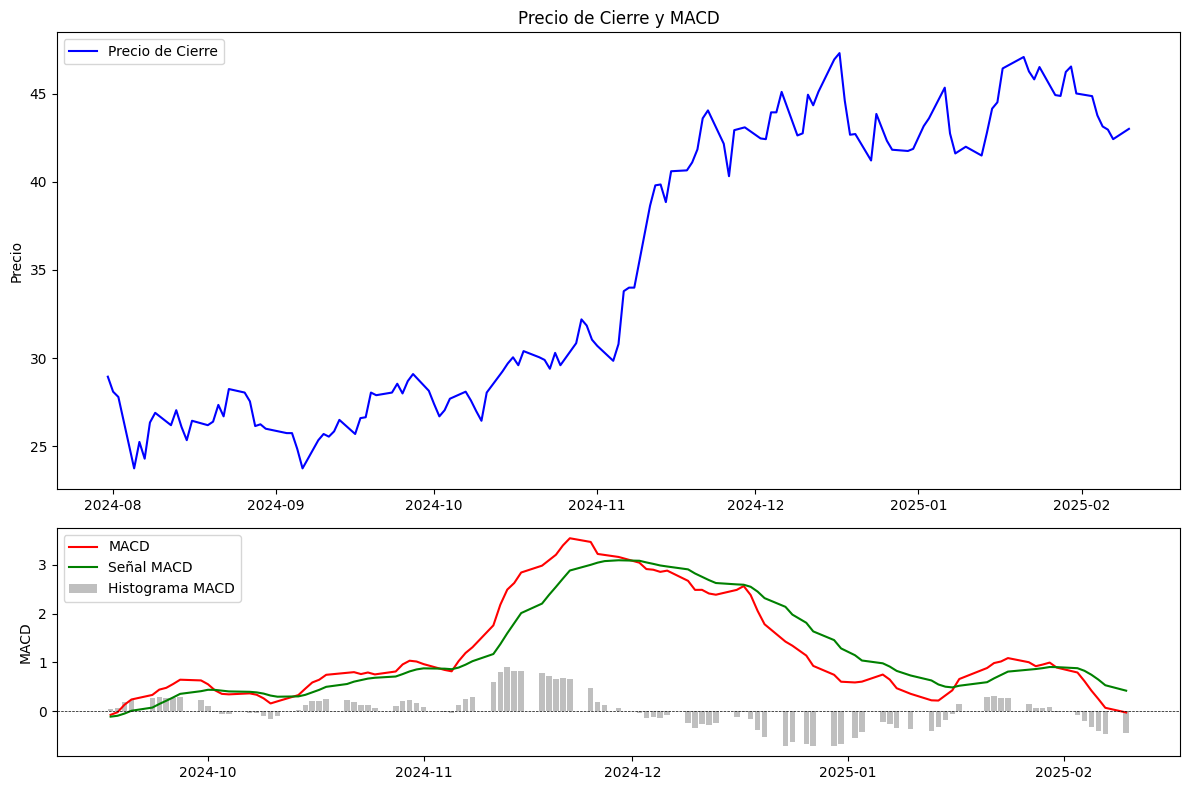

In [ ]:
# Crear una figura y un conjunto de subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Gráfico 1: Precio de cierre y medias móviles (opcional)
ax1.plot(data['Close'], label='Precio de Cierre', color='blue')
ax1.set_title('Precio de Cierre y MACD')
ax1.set_ylabel('Precio')
ax1.legend(loc='upper left')

# Gráfico 2: MACD, Señal e Histograma
ax2.plot(data['macd'], label='MACD', color='red')
ax2.plot(data['macdSignal'], label='Señal MACD', color='green')
ax2.bar(data.index, data['macdHist'], label='Histograma MACD', color='gray', alpha=0.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Línea horizontal en 0
ax2.set_ylabel('MACD')
ax2.legend(loc='upper left')

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [4]:
ma1=int(input('ma1:'))
ma2=int(input('ma2:'))

ticker_data['ma1']=ticker_data['Close'].rolling(window=ma1,min_periods=1,center=False).mean()
ticker_data['ma2']=ticker_data['Close'].rolling(window=ma2,min_periods=1,center=False).mean()

ticker_data['positions']=0
#positions becomes and stays one once the short moving average is above long moving average
ticker_data['positions'][ma1:]=np.where(ticker_data['ma1'][ma1:]>=ticker_data['ma2'][ma1:],1,0)
#as positions only imply the holding
#we take the difference to generate real trade signal
ticker_data['signals']=ticker_data['positions'].diff()
#oscillator is the difference between two moving average
#when it is positive, we long, vice versa
ticker_data['oscillator']=ticker_data['ma1']-ticker_data['ma2']

NameError: name 'ticker_data' is not defined

In [ ]:
ma1=int(input('ma1:'))
ma2=int(input('ma2:'))
stdate=input('start date in format yyyy-mm-dd:')
eddate=input('end date in format yyyy-mm-dd:')
ticker=input('ticker:')

In [24]:
#simple moving average
def macd(signals):   
    signals['ma1']=signals['Close'].rolling(window=ma1,min_periods=1,center=False).mean()
    signals['ma2']=signals['Close'].rolling(window=ma2,min_periods=1,center=False).mean()
    
    return signals

def signal_generation(df,method):
    
    signals=method(df)
    signals['positions']=0

    #positions becomes and stays one once the short moving average is above long moving average
    signals['positions'][ma1:]=np.where(signals['ma1'][ma1:]>=signals['ma2'][ma1:],1,0)

    #as positions only imply the holding
    #we take the difference to generate real trade signal
    signals['signals']=signals['positions'].diff()

    #oscillator is the difference between two moving average
    #when it is positive, we long, vice versa
    signals['oscillator']=signals['ma1']-signals['ma2']

    return signals


def plot(new, ticker):
    
    #the first plot is the actual close price with long/short positions
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,new['Close'][new['signals']==1],label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,new['Close'][new['signals']==-1],label='SHORT',lw=0,marker='v',c='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    
    plt.show()
    
    #the second plot is long/short moving average with oscillator
    #note that i use bar chart for oscillator
    fig=plt.figure()
    cx=fig.add_subplot(211)

    new['oscillator'].plot(kind='bar',color='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator')

    bx=fig.add_subplot(212)

    new['ma1'].plot(label='ma1')
    new['ma2'].plot(label='ma2',linestyle=':')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    

def main():
    
    #input the long moving average and short moving average period
    #for the classic MACD, it is 12 and 26
    #once a upon a time you got six trading days in a week
    #so it is two week moving average versus one month moving average
    #for now, the ideal choice would be 10 and 21
    
    global ma1,ma2,stdate,eddate,ticker,slicer

    #macd is easy and effective
    #there is just one issue
    #entry signal is always late
    #watch out for downward EMA spirals!
    ma1=int(input('ma1:'))
    ma2=int(input('ma2:'))
    stdate=input('start date in format yyyy-mm-dd:')
    eddate=input('end date in format yyyy-mm-dd:')
    ticker=input('ticker:')

    #slicing the downloaded dataset
    #if the dataset is too large, backtesting plot would look messy
    #you get too many markers cluster together
    slicer=int(input('slicing:'))

    #downloading data
    df=yf.download(ticker,start=stdate,end=eddate)
    
    new=signal_generation(df,macd)
    new=new[slicer:]
    plot(new, ticker)


#how to calculate stats could be found from my other code called Heikin-Ashi
# https://github.com/je-suis-tm/quant-trading/blob/master/heikin%20ashi%20backtest.py


if __name__ == '__main__':
    main()

ValueError: invalid literal for int() with base 10: ''